# End to End test using model without pretraining

In [1]:
!apt-get install -q openslide-tools
!apt-get install -q rsync
!pip install openslide-python
!pip install tensorflow-gpu==2.0.0-alpha
!pip install -q scikit-plot
!apt-get install git-lfs

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 16 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (927 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 130811 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os, random, re, time, shutil
from PIL import Image
from skimage.color import rgb2gray
import scikitplot as skplt

import tensorflow as tf
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, layers, models
from tensorflow.keras.applications import InceptionV3



print(tf.__version__)

2.0.0-alpha0


#Useful Functions

## Image Processing
###Utility Functions

In [0]:
# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

# return the coordinates of tumor pixels
def find_tumor_pixels(m):
  return [(j, i) for i, row in enumerate(m)
              for j, c in enumerate(row) if c]

# return the coordinates of tissue pixels
# the black region (higher intensity) should be the background
def find_tissue_pixels(s, intensity=0.8):
  s_gray = rgb2gray(s)
  idx = np.where(s_gray <= intensity)
  return zip(idx[1], idx[0])

# return the coordinates of tumor pixels
def _get_helper(slide_path, mask_path):
  slide, mask = open_slide(slide_path), open_slide(mask_path)
  s = read_slide(slide, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])
  m = read_slide(mask, x=0, y=0, level=7, width=mask.level_dimensions[7][0], height=mask.level_dimensions[7][1])[:,:,0]
  return slide, mask, s, m

# return the set of tissue pixels, the set of tumor pixels, normal pixels
def _get_locs(slide_path, mask_path):
  slide, mask, s, m = _get_helper(slide_path, mask_path)
  loc_tissue = set(find_tissue_pixels(s))
  loc_tumor = set(find_tumor_pixels(m))
  loc_normal = loc_tissue - loc_tumor
  return loc_tissue, loc_tumor, loc_normal

# return a region from the slide which is a numpy RGB array
def get_patch(slide, x, y, width, height):
  patch = read_slide(slide, x=x, y=y, level=0, width=width, height=height)
  return patch

# print slide
def _print_slide(slide_path, sz=10):
  mask_path = slide_path.split('.')[0] + '_mask.tif'
  slide, mask, s, m = _get_helper(slide_path, mask_path)
  plt.figure(figsize=(sz, sz))
  plt.imshow(s)
  plt.imshow(m, cmap='jet', alpha=0.5)
  plt.title(slide_path.split('/')[-1])

###Functions for fetching data and extracting patches 

In [0]:
def _myFetch(filenames):
  if not os.path.exists('slides'):
    os.mkdir('slides')
  _root = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/my_slides'
  for filename in filenames:
    slide_path = os.path.join(_root, 'Copy of ' + filename)
    mask_path = os.path.join(_root, 'Copy of ' + filename.split('.')[0]+'_mask.tif')
    print('fetching %s ..' %filename)
    shutil.copyfile(slide_path, 'slides/'+filename)
    shutil.copyfile(mask_path, 'slides/'+filename.split('.')[0]+'_mask.tif')
  

# extract tumor patches and normal patches from tumor slides
def _extract_tumor_slides(filenames):
  if not os.path.exists('patches'):
    os.mkdir('patches')
  if not os.path.exists('patches/tumor'):
    os.mkdir('patches/tumor')
  if not os.path.exists('patches/normal'):
    os.mkdir('patches/normal')
  slides = ['slides/%s' %filename for filename in filenames]
  masks = [path.split('.')[0]+'_mask.tif' for path in slides]
  for slide_path, mask_path in zip(slides, masks):
    slide_name = slide_path.split('/')[-1].split('.')[0]
    slide, mask, s, m = _get_helper(slide_path, mask_path)
    loc_tissue, loc_tumor, loc_normal = _get_locs(slide_path, mask_path)
    THRESH = len(loc_tumor) // 3
    _num_tumor, _num_normal = 0, 0
    
    samples = random.sample(loc_tumor, THRESH)
  
    for x, y in samples:
      if get_patch(mask, x*128, y*128, 128, 128)[:,:,0].any(): # is tumor
        patch = get_patch(slide, max(0, x*128-85), max(0, y*128-85), 299, 299) # extract the context
        img = Image.fromarray(patch, 'RGB')
        img.save('patches/tumor/{}_{}_{}.png'.format(slide_name, x, y))
        _num_tumor += 1
    
    samples = random.sample(loc_normal, _num_tumor//2)
    for x, y in samples:
      if not get_patch(mask, x*128, y*128, 128, 128)[:,:,0].any(): # is normal
        patch = get_patch(slide, max(0, x*128-85), max(0, y*128-85), 299, 299)
        img = Image.fromarray(patch, 'RGB')
        img.save('patches/normal/{}_{}_{}.png'.format(slide_name, x, y))
        _num_normal += 1
    print('extracted: {:>20} ||  tumor patches {:<7} || normal patches {:<7}'.format(slide_name, _num_tumor, _num_normal))  

# extract normal patches from normal slides
def _extract_normal_slides(filenames, THRESH):
  if not os.path.exists('patches'):
    os.mkdir('patches')
  if not os.path.exists('patches/tumor'):
    os.mkdir('patches/tumor')
  if not os.path.exists('patches/normal'):
    os.mkdir('patches/normal')
  slides = ['slides/%s' %filename for filename in filenames]
  masks = [path.split('.')[0]+'_mask.tif' for path in slides]
  for slide_path, mask_path in zip(slides, masks):
    slide_name = slide_path.split('/')[-1].split('.')[0]
    slide, mask, s, m = _get_helper(slide_path, mask_path)
    loc_tissue, loc_tumor, loc_normal = _get_locs(slide_path, mask_path)
    
    _num_normal = 0
    samples = random.sample(loc_normal, min(THRESH, len(loc_normal)))
    for x, y in samples:
      if not get_patch(mask, x*128, y*128, 128, 128)[:,:,0].any(): # is normal
        patch = get_patch(slide, max(0, x*128-85), max(0, y*128-85), 299, 299)
        img = Image.fromarray(patch, 'RGB')
        img.save('patches/normal/{}_{}_{}.png'.format(slide_name, x, y))
        _num_normal += 1
    print('extracted: {:>20} ||  tumor patches {:<7} || normal patches {:<7}'.format(slide_name, 0, _num_normal))      

##Model 
###Functions for creating, testing, and evaluating models

In [0]:
# create a model without pretraining
def create_model_nopre():
  conv_base = InceptionV3(weights=None, include_top=False, input_shape=(299, 299, 3))
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])
  return model

# test our model on a new test slide
def test_model(filename, model):
  slide_path = 'slides/' + filename
  mask_path = 'slides/' + filename.split('.')[0] + '_mask.tif'
  slide, mask, s, m = _get_helper(slide_path, mask_path)
  loc_tissue, loc_tumor, loc_normal = _get_locs(slide_path, mask_path)
  print('predicting on %i tissues' %len(loc_tissue))
  s_mask = np.zeros(shape=m.shape, dtype=float)
  i = 1
  for x, y in tqdm(loc_tissue):
#     if i % 2000 == 0:
#       print('predicting {:>7} / {} || {:<4f} %'.format(i, len(loc_tissue), 100 * i / len(loc_tissue)))
    patch = get_patch(slide, max(0, x*128-85), max(0, y*128-85), 299, 299) # needs to normalize
    patch = patch / 255
    patch = np.expand_dims(patch, axis=0)
    pred = model.predict(patch)
    s_mask[y][x] = pred[0][0]
    i += 1
  return s_mask

# test our model on some slices of the test slide since the test slide contains too many patches
def test_model_in_parts(filename, model, _slice):
  slide_path = 'slides/' + filename
  mask_path = 'slides/' + filename.split('.')[0] + '_mask.tif'
  slide, mask, s, m = _get_helper(slide_path, mask_path)
  loc_tissue, loc_tumor, loc_normal = _get_locs(slide_path, mask_path)
  print('predicting on %i tissues' %len(loc_tissue))
  s_mask = np.zeros(shape=m.shape, dtype=float)
  i = 1
  for x, y in list(loc_tissue)[_slice]:
    if i % 2000 == 0:
      print('predicting {:>7} / {} || {:<4f} %'.format(i, len(loc_tissue), 100 * i / len(loc_tissue)))
    patch = get_patch(slide, max(0, x*128-85), max(0, y*128-85), 299, 299) # needs to normalize
    patch = patch / 255
    patch = np.expand_dims(patch, axis=0)
    pred = model.predict(patch)
    s_mask[y][x] = pred[0][0]
    i += 1
  return s_mask

# print the groud truth and prediction result
def _print_test(filename, s_mask):
  slide_path, mask_path = 'slides/'+filename, 'slides/'+filename.split('.')[0]+'_mask.tif'
  slide, mask, s, m = _get_helper(slide_path, mask_path)
  plt.figure(figsize=(20, 20))
  plt.title(filename)
  plt.subplot(1, 2, 1)
  plt.imshow(s)
  plt.imshow(m, cmap='jet', alpha=0.5)
  plt.title('ground truth')
  plt.subplot(1, 2, 2)
  plt.imshow(s)
  plt.imshow(s_mask, cmap='jet', alpha=0.5)
  plt.title('predicted heatmap')

# plot ROC curve and get the AUC value  
def _plot_auc(filename, s_mask):
  slide_path, mask_path = 'slides/'+filename, 'slides/'+filename.split('.')[0]+'_mask.tif'
  slide, mask, s, m = _get_helper(slide_path, mask_path)
  y_true = m.reshape((-1,))
  y_tumor = s_mask.reshape((-1,))
  y_normal = 1 - y_tumor
  y_probas = np.array(list(zip(y_normal, y_tumor)))
  skplt.metrics.plot_roc_curve(y_true, y_probas)
  plt.show()  

In [6]:
if not os.path.exists('DL_final_project_2019'):
  !git clone https://github.com/TIANBOQIU/DL_final_project_2019.git
  os.chdir('DL_final_project_2019')  

Cloning into 'DL_final_project_2019'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10 (delta 1), reused 9 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.


In [7]:
!ls

models.zip  slides


In [8]:
!git lfs pull

Git LFS: (3 of 3 files) 1.86 GB / 1.86 GB


In [11]:
!unzip models.zip

Archive:  models.zip
   creating: models/InceptionV3_nopre_ck4/
  inflating: models/InceptionV3_nopre_ck4/checkpoint  
  inflating: models/InceptionV3_nopre_ck4/InceptionV3_nopre_checkpoint4.data-00000-of-00001  
  inflating: models/InceptionV3_nopre_ck4/InceptionV3_nopre_checkpoint4.index  


In [12]:
!ls

models	models.zip  slides


In [13]:
!ls models

InceptionV3_nopre_ck4


In [14]:
!ls models/InceptionV3_nopre_ck4/

checkpoint
InceptionV3_nopre_checkpoint4.data-00000-of-00001
InceptionV3_nopre_checkpoint4.index


#Test Example

**We use tumor_064.tif for this end to end test script**

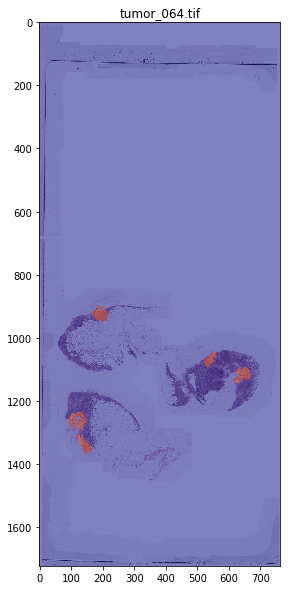

In [15]:
_print_slide('slides/tumor_064.tif')

##1.  Load Weights

(1) The model we use in this end to end test script is a model that is trained from scratch and based on InceptionV3.

(2) Data augmentaion is used in the training step.

In [0]:
model = create_model_nopre()

In [17]:
model.load_weights(os.path.join('models', 'InceptionV3_nopre_ck4/InceptionV3_nopre_checkpoint4')) # weights loaded

## 2. Test

We use AUC as the metric.

In [18]:
_ts = time.time()
s_mask_064 = test_model('tumor_064.tif', model)
print('Done {} s'.format(time.time()-_ts))

  0%|          | 0/65796 [00:00<?, ?it/s]

predicting on 65796 tissues


100%|██████████| 65796/65796 [31:18<00:00, 35.02it/s]


Done 1879.3094472885132 s


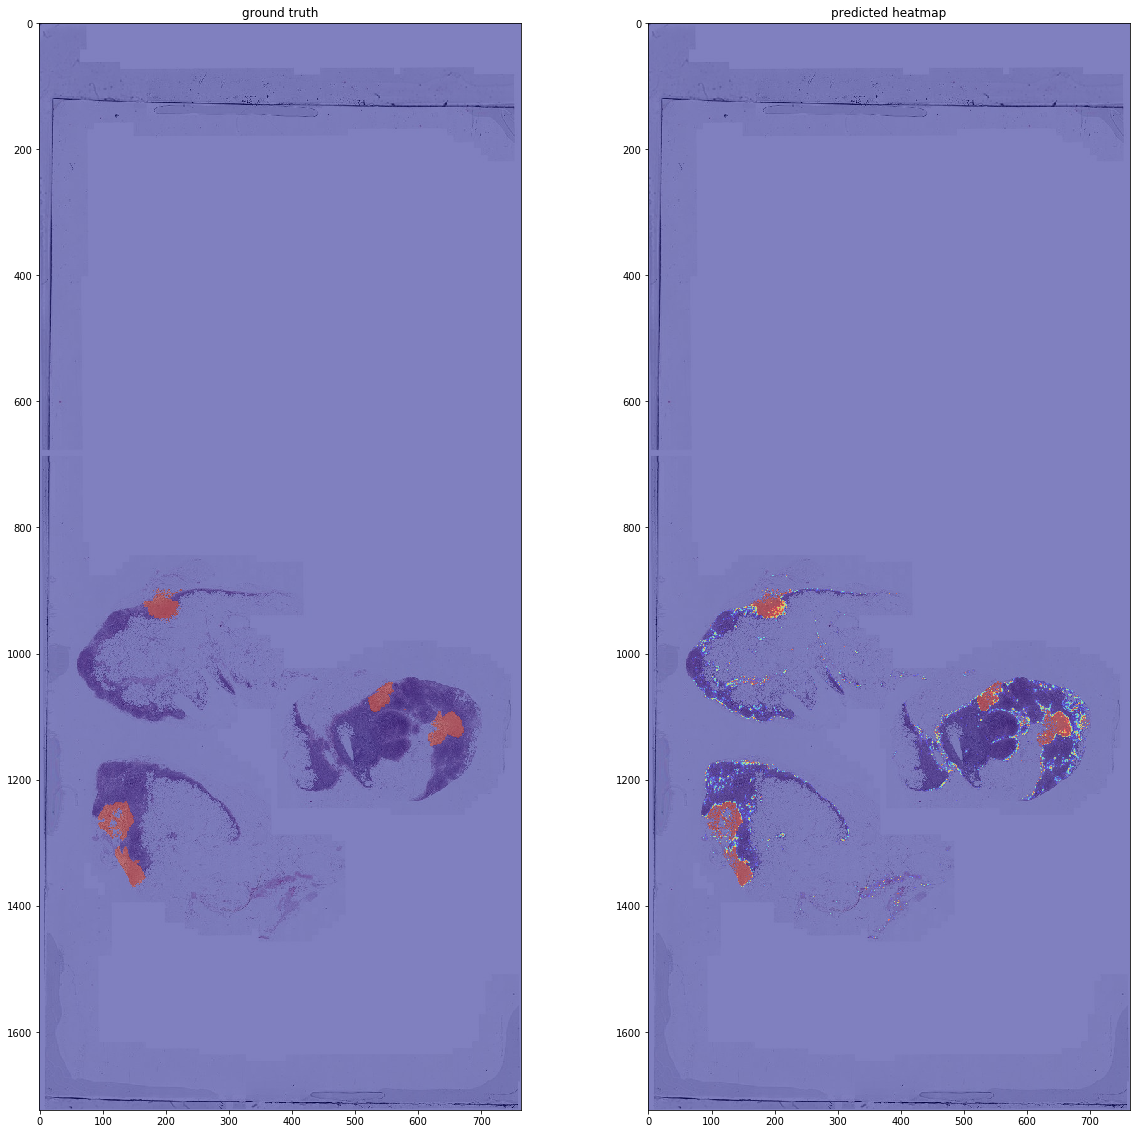

In [19]:
_print_test('tumor_064.tif', s_mask_064)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


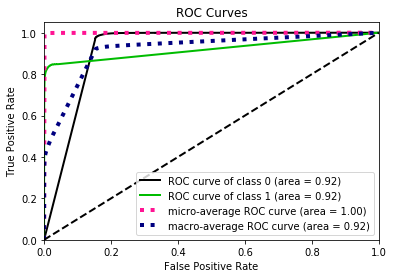

In [20]:
_plot_auc('tumor_064.tif', s_mask_064)